In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TF version: 2.15.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras import layers, Sequential

In [3]:
# !mkdir -p ./data/
# # Download the dataset and store the tar.gz file in Google Drive
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ./data/cifar-10-python.tar.gz

# # Extract the dataset in the home directory (/content/)
# !tar -xzf ./data/cifar-10-python.tar.gz -C ./data/

In [4]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Define the path to the extracted dataset
cifar10_dir = './data/cifar-10-batches-py'

# Load the data batches
data_batches = []
labels = []

for i in range(1, 6):
    batch_path = os.path.join(cifar10_dir, f'data_batch_{i}')
    batch_data = unpickle(batch_path)
    data_batches.append(batch_data[b'data'])
    labels.extend(batch_data[b'labels'])

# Load the test batch
test_batch_path = os.path.join(cifar10_dir, 'test_batch')
test_batch_data = unpickle(test_batch_path)
test_data = test_batch_data[b'data']
test_labels = test_batch_data[b'labels']

# Load the labels
label_names_path = os.path.join(cifar10_dir, 'batches.meta')
label_names = unpickle(label_names_path)[b'label_names']

# Concatenate the training data and labels
train_data = np.concatenate(data_batches)
train_labels = np.array(labels)
test_labels = np.array(test_labels)

In [5]:
print("all the lables names: ", label_names)
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Reshaped training data shape:", train_data.shape)
print("Reshaped test data shape:", test_data.shape)

all the lables names:  [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)
Reshaped training data shape: (50000, 32, 32, 3)
Reshaped test data shape: (10000, 32, 32, 3)


[ 6455 28533 16281 15457 31078   458 42489 33164 36098 35539]


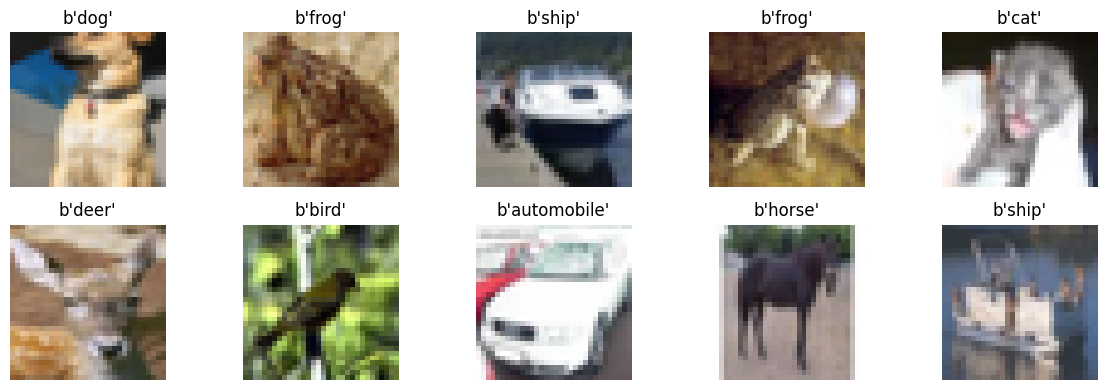

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a few random indices
num_images = 10
indices = np.random.choice(len(train_data), num_images, replace=False)
print(indices)
# Plot the selected images
plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_data[idx])
    plt.title(label_names[train_labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    .shuffle(10000)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_data, test_labels))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("Pipeline ready")


Pipeline ready


In [8]:
class LRNLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        return tf.nn.local_response_normalization(
            x,
            depth_radius=5,
            bias=2.0,
            alpha=1e-4,
            beta=0.75
        )

The AlexNet model was adapted for the CIFAR-10 dataset by resizing 32×32 input images to 128×128 (instead of 227×227) and reducing the size of the fully connected layers due to hardware limitations on the training system. Instead of the original 9216–4096–4096 configuration, two dense layers with 1028 and 512 neurons were employed, followed by a 10-class softmax output layer. This modification significantly lowers the number of trainable parameters while preserving the core convolutional architecture of AlexNet and enabling efficient training within the available computational resources.

In [9]:
alexnet = Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Resizing(128, 128),
    layers.Conv2D(96, 5, strides=1, activation="relu"),
    LRNLayer(),
    layers.MaxPooling2D(3, strides=2),

    layers.Conv2D(256, 5, padding="same", activation="relu"),
    LRNLayer(),
    layers.MaxPooling2D(3, strides=2),

    layers.Conv2D(384, 3, padding="same", activation="relu"),
    layers.Conv2D(384, 3, padding="same", activation="relu"),
    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(3, strides=2),

    layers.Flatten(),
    layers.Dense(1028, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax")
])

alexnet.compile(
    optimizer=tf.keras.optimizers.legacy.SGD(
        learning_rate=0.01,
        momentum=0.9,
        decay=5e-4
    ),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

alexnet.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 96)      7296      
                                                                 
 lrn_layer (LRNLayer)        (None, 124, 124, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       614656    
                                                                 
 lrn_layer_1 (LRNLayer)      (None, 61, 61, 256)       0         
                                                        

In [10]:
history = alexnet.fit(
    train_ds,
    epochs=30,
    validation_data=test_ds
)

Epoch 1/30
782/782 [==============================] - 77s 91ms/step - loss: 1.9948 - accuracy: 0.2578 - val_loss: 1.6291 - val_accuracy: 0.4154
Epoch 2/30
782/782 [==============================] - 70s 89ms/step - loss: 1.4919 - accuracy: 0.4561 - val_loss: 1.2609 - val_accuracy: 0.5409
Epoch 3/30
782/782 [==============================] - 70s 89ms/step - loss: 1.2318 - accuracy: 0.5563 - val_loss: 1.0733 - val_accuracy: 0.6147
Epoch 4/30
782/782 [==============================] - 70s 89ms/step - loss: 1.0438 - accuracy: 0.6293 - val_loss: 0.9314 - val_accuracy: 0.6700
Epoch 5/30
782/782 [==============================] - 70s 89ms/step - loss: 0.8871 - accuracy: 0.6889 - val_loss: 0.8563 - val_accuracy: 0.7012
Epoch 6/30
782/782 [==============================] - 70s 89ms/step - loss: 0.7702 - accuracy: 0.7306 - val_loss: 0.8144 - val_accuracy: 0.7169
Epoch 7/30
782/782 [==============================] - 70s 89ms/step - loss: 0.6552 - accuracy: 0.7673 - val_loss: 0.7668 - val_accuracy:

In [11]:
def plot_history(history):
  # Get accuracy and loss from history
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']
  train_loss = history['loss']
  val_loss = history['val_loss']

  epochs_range = range(len(train_acc))

  # Plot Training and Validation Accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Plot Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

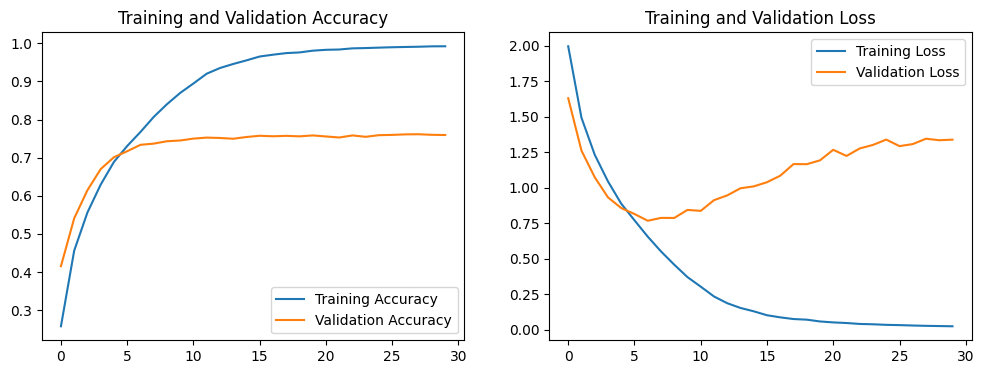

In [12]:
plot_history(history.history)

In [13]:
# save the model and history
alexnet.save('alexnet_cifar10_model.h5')
import pickle
with open('alexnet_cifar10_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

/home/rover/miniconda3/envs/tf-best/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
